# 作成したモデルを使用する

## 動作確認済み環境

- Windows10
- Anaconda3
- python3.7
- チュートリアル動かす以外にinstallしたモジュール(pillow, pandas) 
- current directoryに puyodataフォルダを追加  
　　　　　　　　　　　　　

In [1]:
# puyo_load_data()の定義
# データセット読み込みインタフェース

# number⇒ぷよ色変換const変数
num2color = ['No', 'Red', 'Green', 'Blue', 'Yellow', 'Purple', 'Ojama', 'Unknown']

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def puyo_load_data():
    puyo_type = 8
    train_data_num = 600 * puyo_type
    test_data_num = 100 * puyo_type

    #返すデータ変数の生成
    x_train = []
    y_train = []
    x_test = []
    y_test = []

    #正解ファイル読み込み
    train_csv = pd.read_csv(filepath_or_buffer='puyodata/train/train.csv', encoding="utf_8", sep=",")
    train_data = train_csv[['num', 'color']] 
    test_csv = pd.read_csv(filepath_or_buffer='puyodata/test/test.csv', encoding="utf_8", sep=",")
    test_data = test_csv[['num', 'color']] 


    #データの格納(入力データ読み込みと同時に行う)
    for i in range(train_data_num):
        img = cv2.imread("puyodata/train/img/" + str(i) + ".png", 1)
        # img = img.convert("RGB")
        x_train.append(img)    
        y_train.append(train_data['color'][i])

    for i in range(test_data_num):
        img = cv2.imread("puyodata/test/img/" + str(i) + ".png", 1)
        # img = img.convert("RGB")
        x_test.append(img)
        y_test.append(test_data['color'][i])
        
    x_train = np.array(x_train)
    x_test = np.array(x_test)
    y_train = np.array(y_train)
    y_test = np.array(y_test)

    return (x_train, y_train), (x_test, y_test)

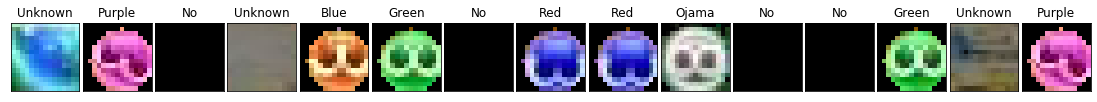

In [2]:
# データ読み込みと表示

%matplotlib inline
import matplotlib.pyplot as plt

# データの読み込み
(x_train, y_train), (x_test, y_test) = puyo_load_data()

fig = plt.figure(figsize=(15, 15))
fig.subplots_adjust(left=0, right=1, bottom=0, top=0.5, hspace=0.05, wspace=0.05)

# 各MNIST画像の上に（タイトルとして）対応するラベルを表示
for i in range(15):
    ax = fig.add_subplot(1, 15, i + 1, xticks=[], yticks=[])
    ax.set_title(num2color[y_train[i]])
    ax.imshow(x_train[i])

In [3]:
# データの正規化
from tensorflow.keras.utils import to_categorical
# 入力画像を行列(15x15×3)からベクトル(長さ675)に変換
#x_train = x_train.reshape(-1, 675)
#x_test = x_test.reshape(-1, 675)

# 入力画像正規化
x_train = x_train.astype('float32')
x_train = x_train / 255.0
x_test = x_test.astype('float32')
x_test = x_test / 255.0

# 名義尺度の値をone-hot表現へ変換
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Using TensorFlow backend.






[0. 0. 1. 0. 0. 0. 0. 0.]
[7.7422700e-11 1.9272244e-12 9.9933356e-01 7.3046473e-12 1.8253263e-06
 8.3225684e-13 3.5025558e-08 6.6458539e-04]
この画像は0.99933356の確率でGreen


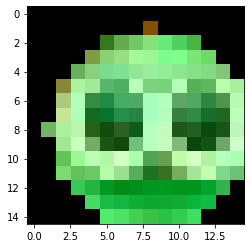

In [4]:
# モデルの読み込み

import keras 
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.models import model_from_json    # モデルを読み込む際に必要


json_string = open('./model/cnn_model.json').read()
model = model_from_json(json_string)
model.load_weights('./model/cnn_model_weights.hdf5')

classes = model.predict(x_test, batch_size=10)

plt.imshow(x_test[4])
print(y_test[4])
print(classes[4])
print("この画像は" + str(max(classes[4])) + "の確率で" + num2color[np.argmax(classes[4])])

# ぷよぷよの対戦動画からフィールドの状態を認識する

In [9]:
import csv

class PField():
    W = 6
    H = 12

class PColor():
    NO = 0
    R = 1
    G = 2
    B = 3
    Y = 4
    P = 5
    OJAMA = 6
    Unknown = 7

    def CVColor(color):
        if color == 1:
            return (0, 0, 255, 128)
        if color == 2:
            return (0, 255, 0, 128)
        if color == 3:
            return (255, 0, 0, 128)
        if color == 4:
            return (0, 255, 255, 128)
        if color == 5:
            return (255, 0, 255, 128)
        if color == 6:
            return (200, 200, 200, 128)
        return (0, 0, 0)

class FieldInfo():
    def __init__(self, fName):
        self.fName = fName
        self.__SetFieldInfo()

    def __SetFieldInfo(self):
        csvFile = open(self.fName, "r", encoding="utf-8")
        rowNum = 0
        for row in csv.reader(csvFile):
            if rowNum == 0:
                self.__left = int(row[0])
                self.__top = int(row[1])
                self.__right = int(row[2])
                self.__bottom = int(row[3])
                self.__width = float(row[4])
                self.__height = float(row[5])
            if rowNum == 1:
                self.__nex = [(int(row[0]), int(row[1]), float(row[2])), (int(row[3]), int(row[4]), float(row[5]))]
            if rowNum == 2:
                self.__nexnex = [(int(row[0]), int(row[1]), float(row[2])), (int(row[3]), int(row[4]), float(row[5]))]
            rowNum += 1
    
    def FieldPos(self, x, y):
        tl = (int(self.__left + x * self.__width + 0.5), int(self.__top + y * self.__height + 0.5))
        br = (int(self.__left + (x + 1) * self.__width + 0.5), int(self.__top + (y + 1) * self.__height + 0.5))
        center = (int(self.__left + (x + 0.5) * self.__width + 0.5), int(self.__top + (y + 0.5) * self.__height + 0.5))
        r = int((self.__width + self.__height)/4 + 0.5)
        return {"tl":tl, "br":br, "center":center, "r":r}

    def NextPos(self, which):
        center = (int(self.__nex[which][0] + 0.5), int(self.__nex[which][1] + 0.5))
        r = int(self.__nex[which][2] + 0.5)
        return [center, r]
        
    def NexnexPos(self, which):
        center = (int(self.__nexnex[which][0] + 0.5), int(self.__nexnex[which][1] + 0.5))
        r = int(self.__nexnex[which][2] + 0.5)
        return[center, r]



In [13]:
class OneFrameViewer():
#   refImage = []
    acceptablePercent = 0.1
    def SetRefImage(fName):
        OneFrameViewer.refImage = cv2.imread(fName, 1)
    def SetFieldInfo(f1, f2):
        OneFrameViewer.FieldInfo = [f1, f2]

    def __init__(self, image):
        self.image = image
#        self.now = [PColor.Unknown, PColor.Unknown]
#        self.next = [PColor.Unknown, PColor.Unknown]
#        self.nexnex = [PColor.Unknown, PColor.Unknown]
        self.field = [[[PColor.Unknown for i in range(PField.W)] for j in range(PField.H)] for k in range(2)]
        self.__GetDifferenceImage()
        self.__DecodePuyoField()

    def __GetDifferenceImage(self):
        for x in range(self.image.shape[1]):
            for y in range(self.image.shape[0]):
                flag = 0
                for c in range(3):
                    if abs(self.image[y, x][c] - OneFrameViewer.refImage[y, x][c]) < 100:
                        flag += 1
                if flag == 3:
                    self.image[y, x] = [0,0,0]

    def __DecodePuyoField(self):
        for p in range(2):
            puyos = []
            for y in range(PField.H):
                for x in range(PField.W):
                    info = OneFrameViewer.FieldInfo[p].FieldPos(x,y)
                    tmp = self.image[info['tl'][1] : info['br'][1], info['tl'][0] : info['br'][0]]
                    tmp = cv2.resize(tmp, (15, 15))
                    puyos.append(np.array(tmp))

            puyos = np.array(puyos)
            puyos = puyos.astype('float32')
            puyos = puyos / 255.0
            puyo = model.predict(puyos)
            for y in range(PField.H):
                for x in range(PField.W):
                    if max(puyo[y*6+x]) > OneFrameViewer.acceptablePercent:
                        self.field[p][y][x] = np.argmax(puyo[y*6+x])
                    else:
                        self.field[p][y][x] = 9
               # print("x:" + str(x) + ", y:"+ str(y) + " " + num2color[np.argmax(puyo[y*6+x])] + "  " + str(max(puyo[y*6+x])))
       # print(np.array(self.field))


In [14]:
class OneGameInfo():
    def __init__(self, inputVideoName, outputVideoName, field1Name, field2Name, refImgName):
        self.inputVName = inputVideoName
        self.__LoadVideo()
        self.outputVName = outputVideoName
        self.__CreateVideoFile()
        self.fieldConfigInfo = [FieldInfo(field1Name),FieldInfo(field2Name)]
        OneFrameViewer.SetFieldInfo(self.fieldConfigInfo[0], self.fieldConfigInfo[1])
        OneFrameViewer.SetRefImage(refImgName)
        
    def __LoadVideo(self):
        self.cap = cv2.VideoCapture(self.inputVName)
        if self.cap.isOpened() == False:
            print("{0} を開けません".format(self.inputVName))

    def __CreateVideoFile(self):
        self.width = int(self.cap.get(cv2.CAP_PROP_FRAME_WIDTH))
        self.height = int(self.cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
        self.fps = self.cap.get(cv2.CAP_PROP_FPS)
        fourcc = cv2.VideoWriter_fourcc(*"DIVX")
        self.writer = cv2.VideoWriter(self.outputVName, fourcc, self.fps, (self.width, self.height))
        print(self.fps)

    def CreateFrame(self, step = 30, startFrameNum = 0, endFrameNum = -1, startGameNum = 1):
        self.cap.set(cv2.CAP_PROP_POS_FRAMES, startFrameNum)
        frameNum = startFrameNum
        endFrameNum = self.cap.get(cv2.CAP_PROP_FRAME_COUNT)
        fv = []

        while frameNum < endFrameNum:
            ret, frame = self.cap.read()
            if not ret:
                break  #フレームの取得の失敗or動画末尾に到達した時

            print(frameNum)
            if (frameNum % step) == 0:
                tmp = frame.copy()
                fv = OneFrameViewer(tmp)

            for p in [0, 1]:
                for y in range(PField.H):
                    for x in range(PField.W):
                        color = PColor.CVColor(fv.field[p][y][x])
                        dp = self.fieldConfigInfo[p].FieldPos(x, y)
                        if color != (0, 0, 0):
                            cv2.circle(frame, dp["center"], dp["r"], PColor.CVColor(fv.field[p][y][x]), 2)

            self.writer.write(frame)
            #cv2.imshow("frame", frame)
            #cv2.waitKey(1)
            
            frameNum += 1


#データ読み込む
OneFrameViewer.acceptablePercent = 0.9

video = OneGameInfo("./puyovideo/puyovideo.mp4", "./puyovideo/result.avi", "./puyovideo/puyovideo1.csv", "./puyovideo/puyovideo2.csv", "./puyovideo/background.jpg")
video.CreateFrame()

695
696
697
698
699
700
701
702
703
704
705
706
707
708
709
710
711
712
713
714
715
716
717
718
719
720
721
722
723
724
725
726
727
728
729
730
731
732
733
734
735
736
737
738
739
740
741
742
743
744
745
746
747
748
749
750
751
752
753
754
755
756
757
758
759
760
761
762
763
764
765
766
767
768
769
770
771
772
773
774
775
776
777
778
779
780
781
782
783
784
785
786
787
788
789
790
791
792
793
794
795
796
797
798
799
800
801
802
803
804
805
806
807
808
809
810
811
812
813
814
815
816
817
818
819
820
821
822
823
824
825
826
827
828
829
830
831
832
833
834
835
836
837
838
839
840
841
842
843
844
845
846
847
848
849
850
851
852
853
854
855
856
857
858
859
860
861
862
863
864
865
866
867
868
869
870
871
872
873
874
875
876
877
878
879
880
881
882
883
884
885
886
887
888
889
890
891
892
893
894
895
896
897
898
899
900
901
902
903
904
905
906
907
908
909
910
911
912
913
914
915
916
917
918
919
920
921
922
923
924
925
926
927
928
929
930
931
932
933
934
935
936
937
938
939
940
941
942
943
944
